In [1]:
# import statements
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib as mpl
from matplotlib import font_manager

In [2]:
# production data
prod = pd.read_csv('Data/brewery_production_2022_interpolated.csv')

# use only applicable columns
cols = ['brewery','latitude','longitude','leg_district','total_annual']
prod = prod[cols]
prod = prod[~prod['total_annual'].isna()] 

# sum data by legislative district
leg_dist_sum = prod[['leg_district','total_annual']].groupby(['leg_district']).sum()
leg_dist_sum.reset_index(inplace=True)

# rename column for merging
leg_dist_sum.rename(columns = {'leg_district':'DISTRICT'}, inplace=True)

In [3]:
# geographic data
dists = geopandas.read_file('Data/Geographic/legislative_districts.geojson')
dists['DISTRICT'] = dists['DISTRICT'].astype(int)

In [4]:
# merge with production data
dists_prod = dists.merge(leg_dist_sum, on='DISTRICT', how='left')
dists_prod.head()

,ID,DISTRICT,DISTRICTN,Shape_Leng,Shape_Le_1,Shape_Le_2,Shape_Area,geometry,total_annual
0,1,1,1.0,0.972558,2.888039e+05,0.972558,0.016812,"POLYGON ((-122.26794 47.71225, -122.26914 47.7...",15149.21
1,2,2,2.0,4.162767,1.177644e+06,4.162767,0.268487,"POLYGON ((-122.31252 46.79597, -122.31239 46.7...",NaN
2,3,3,3.0,0.774628,2.269569e+05,0.774628,0.012813,"POLYGON ((-117.40011 47.58679, -117.40092 47.5...",23210.03
3,4,4,4.0,1.937361,5.943962e+05,1.937361,0.124070,"POLYGON ((-117.27880 47.60939, -117.27756 47.6...",2620.79
4,5,5,5.0,2.797009,7.926247e+05,2.797009,0.137712,"POLYGON ((-121.94648 47.22074, -121.94776 47.2...",3314.36


In [5]:
# city data
cities = geopandas.read_file('Data/Geographic/WA_City_Points.geojson')
cities = cities[cities['NAME'].isin(
    ['Seattle','Bellingham','Spokane','Yakima','Vancouver'])].reset_index(drop=True)
cities.head()

,OBJECTID,NAME,CountySeat,GNIS,LastUpdate,MajorCity,CountyFIPS,CityFIPS,geometry
0,292,Bellingham,yes,2409823,2009-05-31 00:00:00+00:00,yes,73,5305280WA,POINT (-122.47721 48.74848)
1,362,Spokane,yes,2411956,2008-11-30 00:00:00+00:00,yes,63,5367000WA,POINT (-117.42111 47.65787)
2,364,Seattle,yes,2411856,NaT,yes,33,5363000WA,POINT (-122.33759 47.61128)
3,504,Yakima,yes,2412314,2009-05-31 00:00:00+00:00,yes,77,5380010WA,POINT (-120.50614 46.60220)
4,556,Vancouver,yes,2412146,2009-08-31 00:00:00+00:00,yes,11,5374060WA,POINT (-122.67162 45.62879)


In [6]:
# set theme

# use lato font
font_path = 'Reference/Lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# set colors
col_yellow = '#ffa400'
col_green = '#256143'
col_brown = '#9c5421'
col_off_black = '#434343'
mpl.rcParams['text.color'] = col_off_black # title and legend
mpl.rcParams['xtick.color'] = col_off_black # tick marks
mpl.rcParams['ytick.color'] = col_off_black # tick marks
mpl.rcParams['axes.labelcolor'] = col_off_black # axes labels

# set font sizes
mpl.rcParams['axes.titlesize'] = 14 # title
mpl.rcParams['axes.labelsize'] = 12 # axes labels
mpl.rcParams['xtick.labelsize'] = 11 # tick marks
mpl.rcParams['ytick.labelsize'] = 11 # tick marks
mpl.rcParams['legend.title_fontsize'] = 12 # legend title
mpl.rcParams['legend.fontsize'] = 11 # legend text

Text(0.5, 0.97, 'Total Craft Beer Production by Legislative District (2022)')

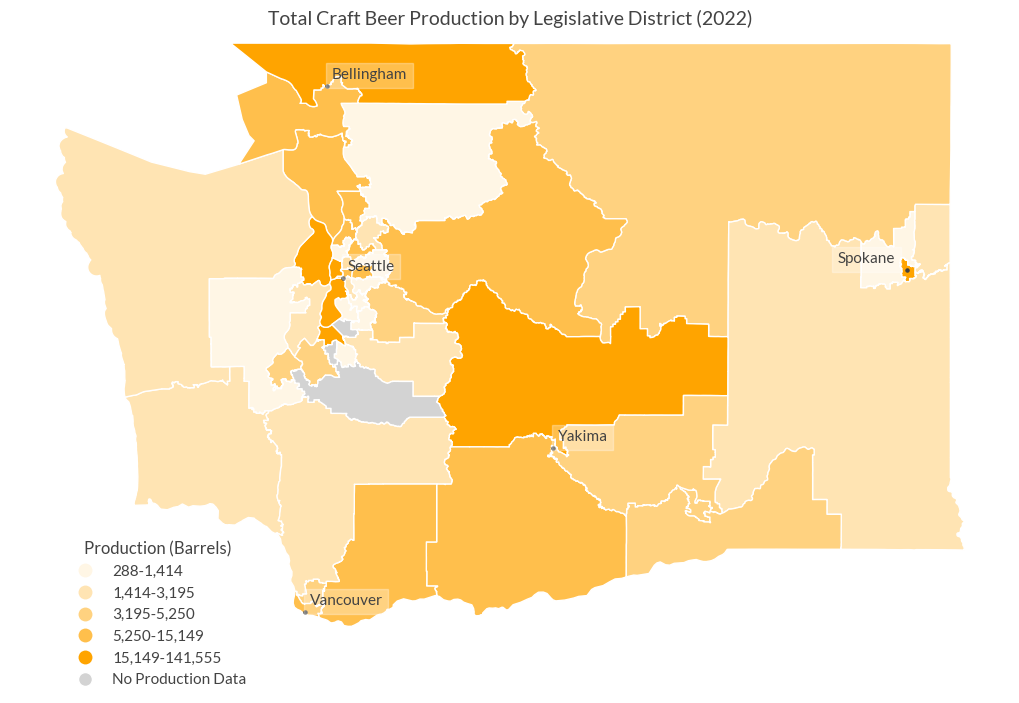

In [7]:
# colors
missing_kwds = dict(color='#D3D3D3', label='No Production Data')
cols = ['#fff6e5','#ffe4b3','#ffd280','#ffbf4d','#ffa400']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cols)

# create map
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_axes([0, 0.01, 1, 1])
ax.axis('off')

dists_prod.plot(
    ax=ax,
    column='total_annual',
    legend = True,
    scheme='quantiles', k=5, cmap=cmap,
    edgecolor='white',
    missing_kwds=missing_kwds)

# add cities
cities.plot(ax=ax, marker='o', color='#434343', markersize=5)
for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities.NAME):
    if label == 'Spokane':
        ax.text(x-0.6, y+.04, label, fontsize=11).set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='white'))
    else:
        ax.text(x+.04, y+.04, label, fontsize=11).set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='white'))

# set legend
leg = ax.get_legend()
leg.get_frame().set_alpha(0)
leg.set_bbox_to_anchor((0, 0, 0.25, 0.2))
leg.get_texts()[0].set_text('288-1,414')
leg.get_texts()[1].set_text('1,414-3,195')
leg.get_texts()[2].set_text('3,195-5,250')
leg.get_texts()[3].set_text('5,250-15,149')
leg.get_texts()[4].set_text('15,149-141,555')
leg.set_title('Production (Barrels)')

# title
plt.title('Total Craft Beer Production by Legislative District (2022)', y=0.97)

In [8]:
# save map
fig.savefig('Viz/Draft2/choropleth_production.png', dpi=1200)

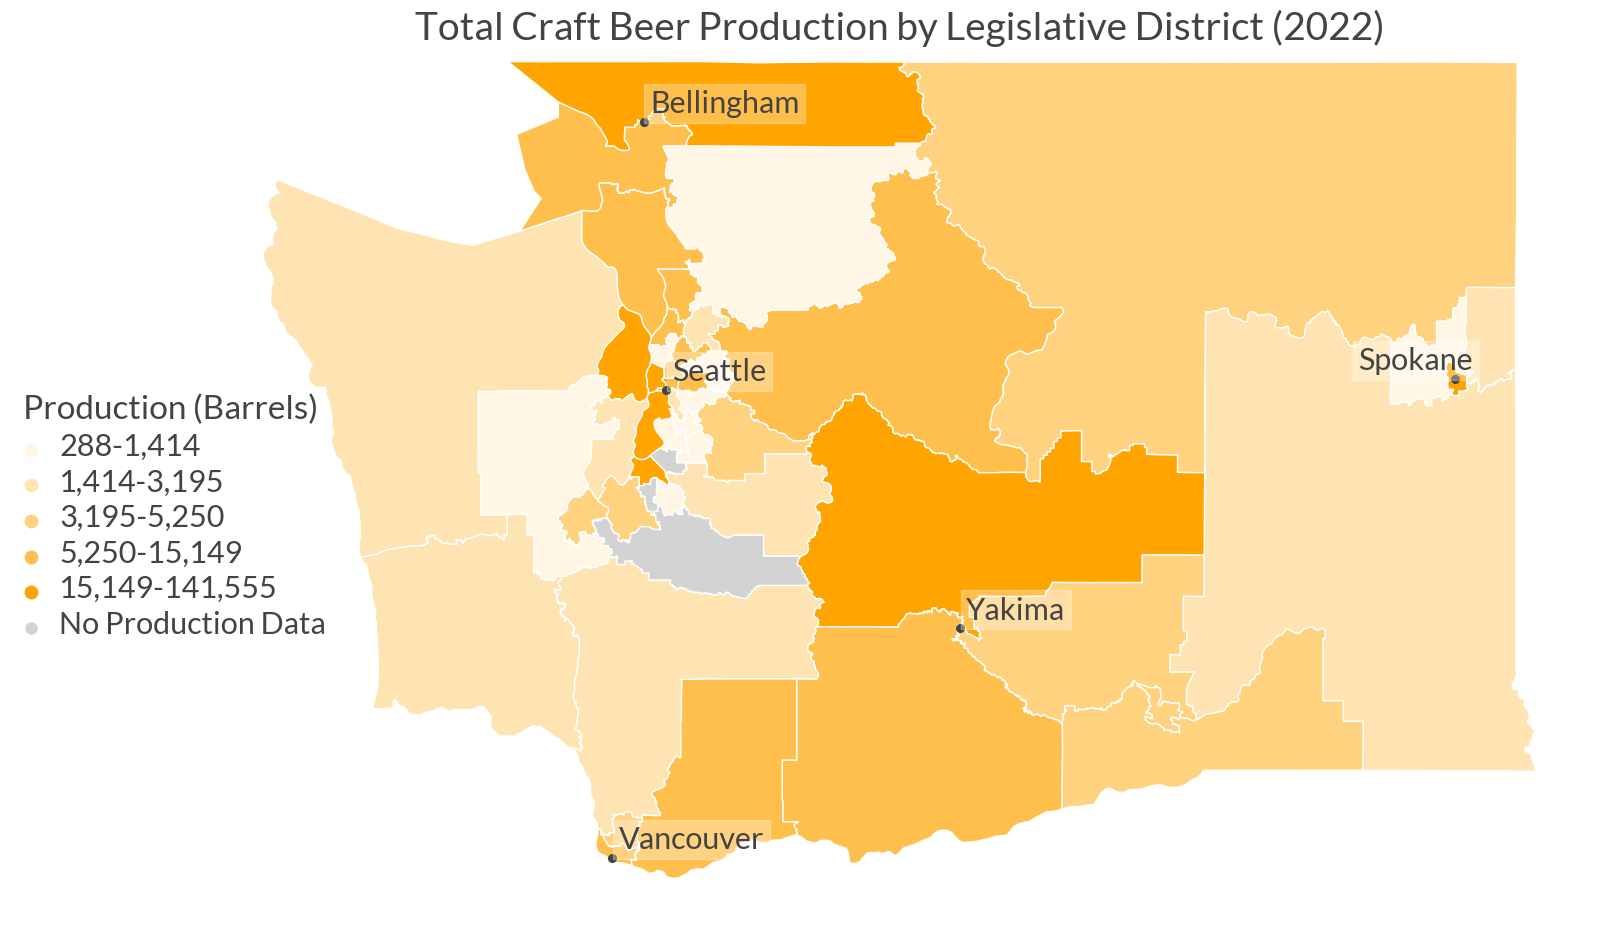

In [9]:
# poster version

# create map
fig = plt.figure(figsize=(14,12))
ax = fig.add_axes([0, 0.01, 1, 1])
ax.axis('off')

dists_prod.plot(
    ax=ax,
    column='total_annual',
    legend = True,
    scheme='quantiles', k=5, cmap=cmap,
    edgecolor='white',
    missing_kwds=missing_kwds)

# add cities
for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities.NAME):
    if label == 'Spokane':
        ax.text(x-0.6, y+.04, label, fontsize=22).set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='white'))
    else:
        ax.text(x+.04, y+.04, label, fontsize=22).set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='white'))
cities.plot(ax=ax, marker='o', color='#434343', markersize=30)
        
# set legend
leg = ax.get_legend()
leg.get_frame().set_alpha(0)
leg.set_bbox_to_anchor((0, 0, 0.1, 0.6))
leg.get_texts()[0].set_text('288-1,414')
leg.get_texts()[1].set_text('1,414-3,195')
leg.get_texts()[2].set_text('3,195-5,250')
leg.get_texts()[3].set_text('5,250-15,149')
leg.get_texts()[4].set_text('15,149-141,555')
leg.set_title('Production (Barrels)')
plt.setp(leg.get_title(),fontsize=24)
plt.setp(leg.get_texts(),fontsize=22)

# title
plt.title('Total Craft Beer Production by Legislative District (2022)', y=0.97, fontsize=28)

# save map
fig.savefig('Viz/Draft2/choropleth_production_poster.png', bbox_inches='tight', dpi=1200)